In [1]:
import numpy as np
import os
import random
import torch

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from Callbacks import EarlyStopping
from TransferLearningModel import TransferLearningModel
from utils import DICOMCoarseDataset, display_data_loader_batch

In [2]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
image_size = 80 #best yet 80 with 87%
classes = ["nodule", "non-nodule"]
train_ratio = 0.6

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

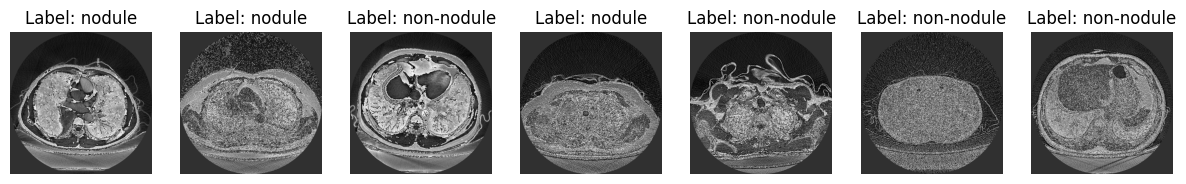

In [3]:
dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=classes, scenario=1)
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=classes, scenario=1)
dataset.visualize_images(num_images=7)

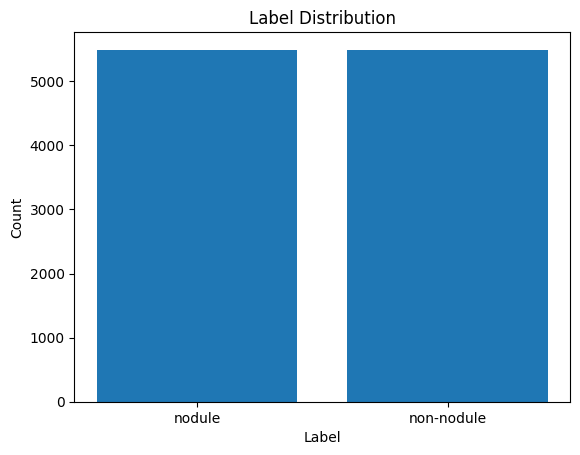

In [4]:
dataset.display_label_distribution()

In [5]:
train_size = int(train_ratio * len(dataset))
val_size = int(((1-train_ratio)/2) * len(dataset)) 
test_size = len(dataset) - train_size - val_size

print(f"Train size: {train_size} --- Validation size: {val_size} --- Test size: {test_size}")

Train size: 6591 --- Validation size: 2197 --- Test size: 2198


In [6]:
model_names = ["resnet", "densenet", "inception", "efficientnet", "vit"]
best_val_loss = float('inf')
best_model = None

for model_name in model_names:
    print(f"Processing model: {model_name}")
    current_model = TransferLearningModel(classes, model_name, data_augmentation=True)

    # Ensure transforms are correctly applied based on model requirements
    current_model.train_transforms, current_model.test_transforms = current_model.get_transforms()
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Apply specific transforms to each subset
    train_dataset.dataset.transform = current_model.train_transforms
    val_dataset.dataset.transform = current_model.test_transforms
    test_dataset.dataset.transform = current_model.test_transforms

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10)

    # Train the current model
    current_model.train(train_loader, val_loader, early_stopping, epochs=50)

    # Track the best model based on validation loss
    final_val_loss = current_model.val_losses[-1]
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = current_model

print(f"The best model is {best_model.model_name} with a validation loss of {best_val_loss:.4f}")

Processing model: resnet
Epoch 1/50 ----- Loss: 0.6227, Accuracy: 65.26% ----- Validation Loss: 0.5830, Validation Accuracy: 68.18%
Epoch 2/50 ----- Loss: 0.5800, Accuracy: 69.52% ----- Validation Loss: 0.5703, Validation Accuracy: 69.55%
Epoch 3/50 ----- Loss: 0.5589, Accuracy: 71.14% ----- Validation Loss: 0.5667, Validation Accuracy: 71.05%
Epoch 4/50 ----- Loss: 0.5442, Accuracy: 72.11% ----- Validation Loss: 0.5989, Validation Accuracy: 69.69%
Epoch 5/50 ----- Loss: 0.5395, Accuracy: 73.16% ----- Validation Loss: 0.5538, Validation Accuracy: 70.96%
Epoch 6/50 ----- Loss: 0.5603, Accuracy: 71.28% ----- Validation Loss: 0.5786, Validation Accuracy: 70.64%
Epoch 7/50 ----- Loss: 0.5267, Accuracy: 73.72% ----- Validation Loss: 0.5447, Validation Accuracy: 71.64%
Epoch 8/50 ----- Loss: 0.5297, Accuracy: 73.57% ----- Validation Loss: 0.5462, Validation Accuracy: 71.05%
Epoch 9/50 ----- Loss: 0.5178, Accuracy: 74.33% ----- Validation Loss: 0.5639, Validation Accuracy: 71.51%
Epoch 10/50 

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\.venv\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/50 ----- Loss: 0.5798, Accuracy: 69.55% ----- Validation Loss: 0.5323, Validation Accuracy: 71.87%
Epoch 2/50 ----- Loss: 0.5142, Accuracy: 74.45% ----- Validation Loss: 0.5145, Validation Accuracy: 74.42%
Epoch 3/50 ----- Loss: 0.4940, Accuracy: 75.77% ----- Validation Loss: 0.5134, Validation Accuracy: 74.92%
Epoch 4/50 ----- Loss: 0.4777, Accuracy: 76.91% ----- Validation Loss: 0.5063, Validation Accuracy: 75.06%
Epoch 5/50 ----- Loss: 0.4654, Accuracy: 78.03% ----- Validation Loss: 0.5120, Validation Accuracy: 73.55%
Epoch 6/50 ----- Loss: 0.4601, Accuracy: 78.21% ----- Validation Loss: 0.4983, Validation Accuracy: 74.33%
Epoch 7/50 ----- Loss: 0.4499, Accuracy: 78.99% ----- Validation Loss: 0.4846, Validation Accuracy: 76.33%
Epoch 8/50 ----- Loss: 0.4475, Accuracy: 78.59% ----- Validation Loss: 0.4901, Validation Accuracy: 74.28%
Epoch 9/50 ----- Loss: 0.4386, Accuracy: 79.35% ----- Validation Loss: 0.4941, Validation Accuracy: 76.19%
Epoch 10/50 ----- Loss: 0.4348, Accur

Best model: efficientnet


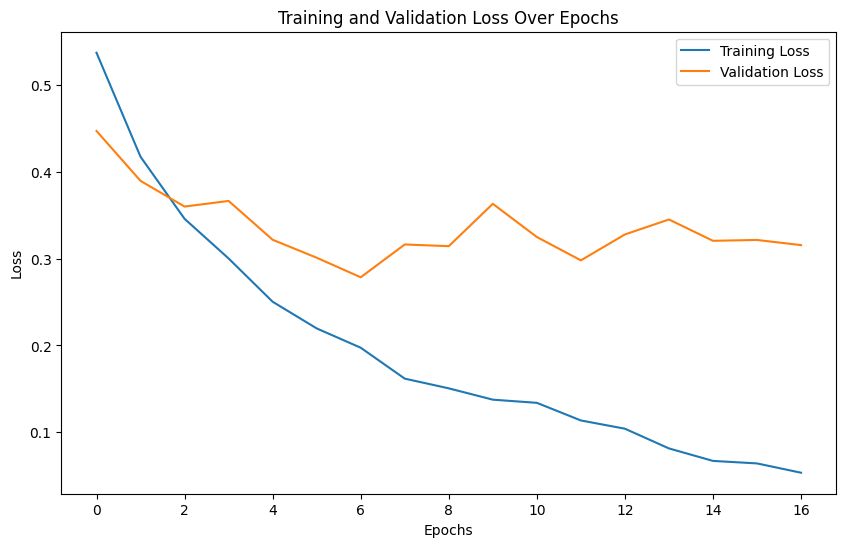

In [7]:
print(f"Best model: {best_model.model_name}")
best_model.plot_loss()

0.2647623664949176
Evaluation Accuracy on unseen data: 93.58507734303913


<Figure size 1000x800 with 0 Axes>

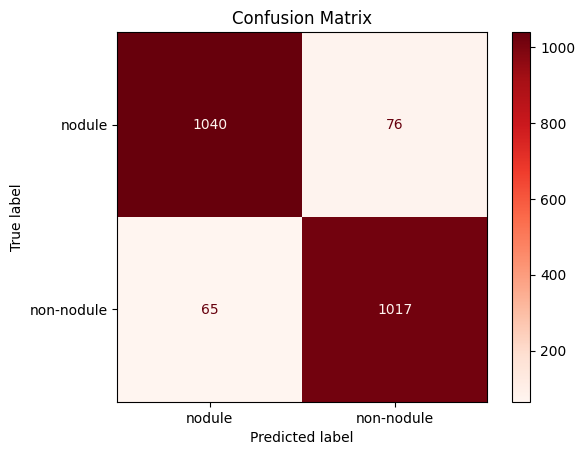

In [24]:
checkpoint = torch.load(f"weights/{best_model.model_name}.pt", weights_only=False)
best_model.model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint["loss"]
print(loss)
best_model.evaluate(test_loader)